# **2)  Analyse et partitionnement de la clientèle d’un grand magasin**

## **2.1)  Examen des données**

In [3]:
import matplotlib.pyplot as plt # Importation des librairies naicessaires du code
import pandas as pd
import io
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.mixture import GaussianMixture

customer_database = pd.read_csv("/content/sample_data/customer_database.csv",sep= ";") #On importe ici le fichier CSV

customer_database.info()
customer_database.describe()
print (customer_database.shape) #On affiche les données principals du fichier CSV magasin
#customer_database.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 2240 non-null   int64  
 1   BirthYear          2240 non-null   int64  
 2   Education          2240 non-null   object 
 3   CivilStatus        2240 non-null   object 
 4   Income             2216 non-null   float64
 5   Kids               2240 non-null   int64  
 6   Teens              2240 non-null   int64  
 7   Registration       2240 non-null   object 
 8   LastPurchase       2240 non-null   int64  
 9   Wines              2240 non-null   int64  
 10  Fruits             2240 non-null   int64  
 11  Meat               2240 non-null   int64  
 12  Fish               2240 non-null   int64  
 13  Sweet              2240 non-null   int64  
 14  Luxury             2240 non-null   int64  
 15  DiscountPurchases  2240 non-null   int64  
 16  WebPurchases       2240 

In [4]:
print(customer_database.describe()) # On affiche les statistiques principales de chaque variable pour détecter des cases NA ou des abérations
#print(customer_database.isna().sum())

                 ID    BirthYear         Income         Kids        Teens  \
count   2240.000000  2240.000000    2216.000000  2240.000000  2240.000000   
mean    5592.159821  1968.805804   52247.251354     0.542411     0.515179   
std     3246.662198    11.984069   25173.076661     3.346318     0.695639   
min        0.000000  1893.000000    1730.000000     0.000000     0.000000   
25%     2828.250000  1959.000000   35303.000000     0.000000     0.000000   
50%     5458.500000  1970.000000   51381.500000     0.000000     0.000000   
75%     8427.750000  1977.000000   68522.000000     1.000000     1.000000   
max    11191.000000  1996.000000  666666.000000   111.000000    21.000000   

       LastPurchase        Wines       Fruits         Meat         Fish  ...  \
count   2240.000000  2240.000000  2240.000000  2240.000000  2240.000000  ...   
mean      49.109375   303.935714    26.302232   166.950000    37.525446  ...   
std       28.962453   336.597393    39.773434   225.715373    54.6

array([[<Axes: title={'center': 'ID'}>,
        <Axes: title={'center': 'BirthYear'}>,
        <Axes: title={'center': 'Income'}>,
        <Axes: title={'center': 'Kids'}>,
        <Axes: title={'center': 'Teens'}>],
       [<Axes: title={'center': 'LastPurchase'}>,
        <Axes: title={'center': 'Wines'}>,
        <Axes: title={'center': 'Fruits'}>,
        <Axes: title={'center': 'Meat'}>,
        <Axes: title={'center': 'Fish'}>],
       [<Axes: title={'center': 'Sweet'}>,
        <Axes: title={'center': 'Luxury'}>,
        <Axes: title={'center': 'DiscountPurchases'}>,
        <Axes: title={'center': 'WebPurchases'}>,
        <Axes: title={'center': 'CatalogPurchases'}>],
       [<Axes: title={'center': 'StorePurchases'}>,
        <Axes: title={'center': 'WebVisits'}>,
        <Axes: title={'center': 'Accept3'}>,
        <Axes: title={'center': 'Accept4'}>,
        <Axes: title={'center': 'Accept5'}>],
       [<Axes: title={'center': 'Accept1'}>,
        <Axes: title={'center': 'A

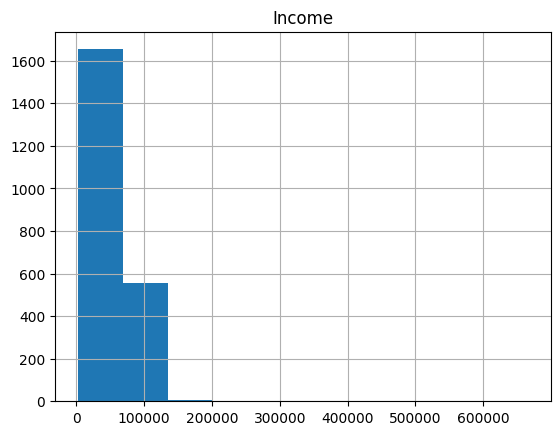

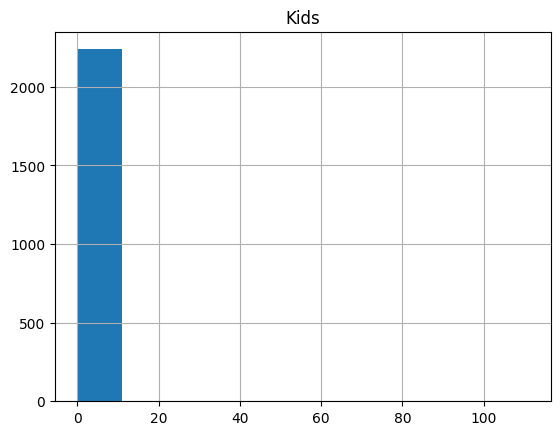

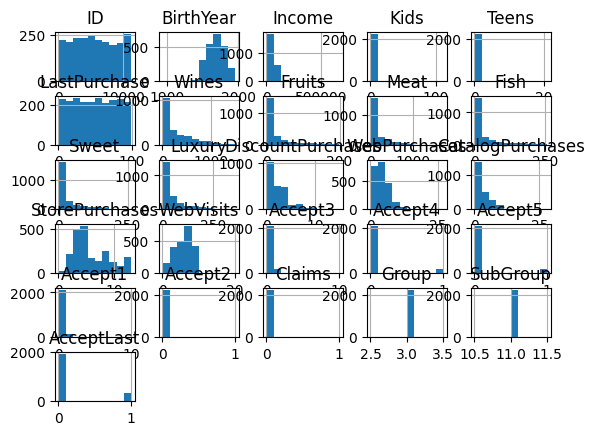

In [5]:
description = customer_database.describe()
#print(description)
customer_database.hist('Income') # On détecte bien des abérations sur les variables Income et Kids
customer_database.hist('Kids')
customer_database.hist()

In [6]:
new_customer = customer_database.drop(columns= ['ID', 'Registration', 'LastPurchase', 'Group', 'SubGroup', 'DiscountPurchases', 'Accept1', 'Accept2', 'Accept3', 'Accept4', 'Accept5', 'AcceptLast'])
columns = new_customer.columns #On décide de retirer certaines colonnes que l'on a jugé inutiles ou inchérentes par rapport à notre objectif
new_customer.head() #Puis d'afficher les variables restantes et de stocker le nom des colonnes dans une variable

,BirthYear,Education,CivilStatus,Income,Kids,Teens,Wines,Fruits,Meat,Fish,Sweet,Luxury,WebPurchases,CatalogPurchases,StorePurchases,WebVisits,Claims
0,1957,Graduation,Single,58138.0,0,0,635,88,546,172,88,88,8,10,4,7,0
1,1954,Graduation,Single,46344.0,1,1,11,1,6,2,1,6,1,1,2,5,0
2,1965,Graduation,Together,71613.0,0,0,426,49,127,111,21,42,8,2,10,4,0
3,1984,Graduation,Together,26646.0,1,0,11,4,20,10,3,5,2,0,4,6,0
4,1981,PhD,Married,58293.0,1,0,173,43,118,46,27,15,5,3,6,5,0


## **2.2)  Pré-traitement des données**

In [7]:
# Remplacement des données manquantes
filled_customer = new_customer.fillna(new_customer['Income'].mean())      # On remplace les valeurs manquantes par la moyenne de sa colonne
                                                                          # En l'occurence ici, on ne remplit que la colonne 'Income', l'unique colonne à en posséder
# Remplacement des données qualitatives

# Colonne BirthYear
filled_customer['BirthYear'] = 2022-filled_customer['BirthYear'] #Ici, remplace dans les données l'année de naissance par l'âge des individus en 2022
filled_customer.drop( filled_customer[filled_customer['BirthYear'] >= 100].index, inplace=True) #Puis on supprime les individus de plus de 100 ans
print (filled_customer.shape)

# Colonne Education
"""
filled_customer = filled_customer.replace('2n Cycle', 0)
filled_customer = filled_customer.replace('Basic', 1)
filled_customer = filled_customer.replace('Master', 2)
filled_customer = filled_customer.replace('PhD', 3)
filled_customer = filled_customer.replace('Graduation', 4)
"""
filled_customer = filled_customer.replace('2n Cycle', 4)  #On a choisi de remplacer les valeurs qualitatives par des valeurs numériques arbitrairement ou non
filled_customer = filled_customer.replace('Basic', 0) #Par exemple, ici, pour la colonne "Education", on choisi d'attribuer des points pour chaque valeur en fonction du nombre d'année détude après la 6ème que ça représente
filled_customer = filled_customer.replace('Master', 10) #afin de quantifier la colonne éducation et pouvoir en tirer des conclusions plus tard
filled_customer = filled_customer.replace('PhD', 12)
filled_customer = filled_customer.replace('Graduation', 15)
print (filled_customer.shape)

# Colonne CivilStatus
filled_customer = filled_customer.replace('Single', 0)  #Pour la colonne "CivilStatus", on a choisi de regrouper les individus en deux catégories, à deux ou tout seul
filled_customer = filled_customer.replace('Alone', 0)
filled_customer = filled_customer.replace('Together', 1)
filled_customer = filled_customer.replace('Married', 1)
filled_customer = filled_customer.replace('Divorced', 0)
filled_customer = filled_customer.replace('Widow', 0)
filled_customer.drop( filled_customer[filled_customer['CivilStatus'] == 'YOLO'].index, inplace=True)  #Pour les valeurs absurdes, on supprime l'individu car impossible de réaliser une moyenne d'une valeur qualitative
filled_customer.drop( filled_customer[filled_customer['CivilStatus'] == 'Absurd'].index, inplace=True)
filled_customer = filled_customer.astype({'CivilStatus' : int})
print (filled_customer.shape)
# On fait le choix de réunir les mêmes situations (single et alone) + on supprime YOLO et Absurd

# Colonne Income
filled_customer.drop( filled_customer[filled_customer['Income'] >= 10*filled_customer['Income'].mean()].index, inplace=True)
print (filled_customer.shape) # On supprime le salaire aberrant (de manière arbitraire, les salaires supérieurs à 10x la moyenne des salaires du groupe)

# Colonne Kids
filled_customer.drop( filled_customer[filled_customer['Kids'] >= 8].index, inplace=True)
print (filled_customer.shape) # On supprime les individus avec + de 8 enfants

# Colonne Teens
filled_customer.drop( filled_customer[filled_customer['Teens'] >= 8].index, inplace=True)
print (filled_customer.shape) # Idem pour les teenagers

"""
# Colonne Accept1
filled_customer.drop( filled_customer[filled_customer['Accept1'] > 1].index, inplace=True)
print (filled_customer.shape)

# Colonne Accept3
filled_customer.drop( filled_customer[filled_customer['Accept3'] > 1].index, inplace=True)
print (filled_customer.shape)
"""

# On centre et réduit la matrice

X = filled_customer
scalerX = StandardScaler()
scalerX.fit(X)                # pour mettre X dans scaler
Z = scalerX.transform(X)      # pour centrer et réduire
scalerZ = StandardScaler()
scalerZ.fit(Z)                # on remplace X
#print (Z)



(2237, 17)
(2237, 17)
(2233, 17)
(2232, 17)
(2230, 17)
(2229, 17)


StandardScaler()

## **2.3)  Recherche de corrélations**

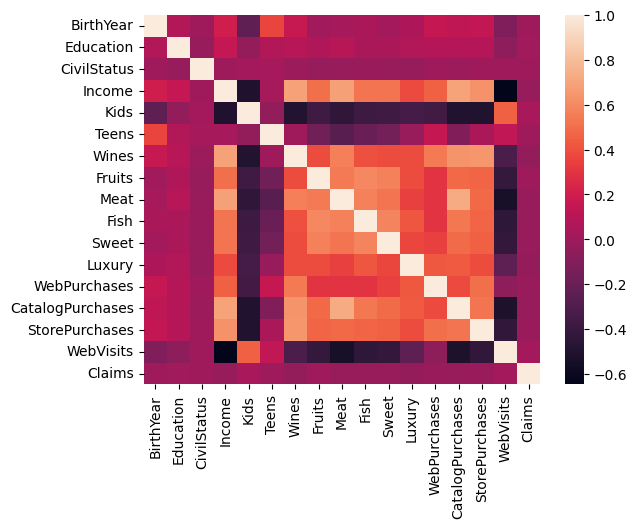

In [8]:
corr = filled_customer.corr()

heat_map = sb.heatmap (corr) #Calcul de la matrice de corrélation ds colonnes et affichage de la Heatmap
plt.show()

## **2.4)  Analyse exploratoire des données**

[6.24249818 1.70269895 1.08074379 1.02352556]
[ 6.24249818  7.94519713  9.02594092 10.04946648]


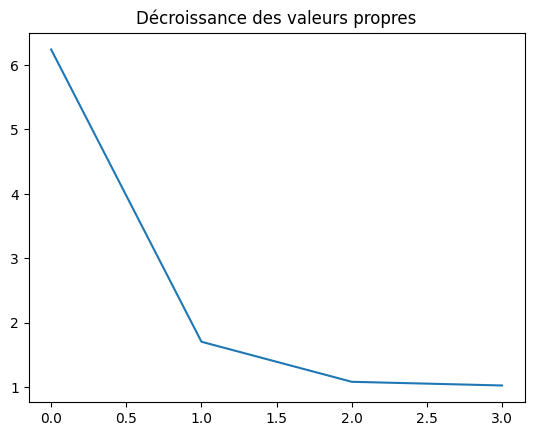

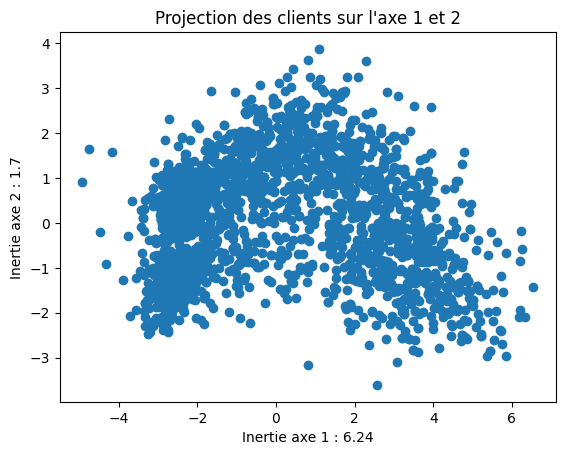

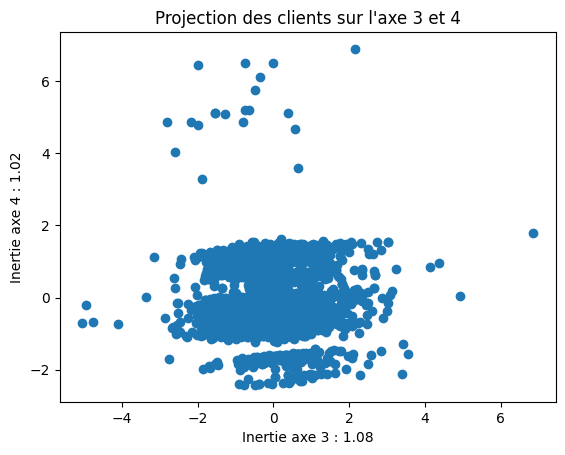

In [9]:
pca = PCA(4) #Calcul de l'ACP pour 4 valeurs propres
pca.fit(Z)

valeursp = pca.explained_variance_
valeursp_cumul =np.cumsum(valeursp)
vecteursp = pca.components_
part_inertie = pca.explained_variance_ratio_
inertie_cumul = np.cumsum(part_inertie) # On décide de garder 4 axes principaux selon la règle de Kaiser (Valeurs propres >= 1)

print (valeursp)
print (valeursp_cumul)
plt.plot (valeursp)
plt.title("Décroissance des valeurs propres")
plt.show()

Zt = pca.transform(Z)

plt.scatter(Zt[:2227,0], Zt[:2227,1])
plt.xlabel("Inertie axe 1 : " + str(round(valeursp[0], 2))) #Affichage du nuage des points selon les 2 premiers axes
plt.ylabel("Inertie axe 2 : " + str(round(valeursp[1], 2)))
plt.title ("Projection des clients sur l'axe 1 et 2")
plt.show()

plt.scatter(Zt[:2227,2], Zt[:2227,3])
plt.xlabel("Inertie axe 3 : " + str(round(valeursp[2], 2))) #Affichage du nuage des points selon les 2 derniers axes
plt.ylabel("Inertie axe 4 : " + str(round(valeursp[3],2)))
plt.title ("Projection des clients sur l'axe 3 et 4")
plt.show()

# plt.scatter(Zt[:500,4], Zt[:500,5])
# plt.xlabel("Inertie axe 5 : " + str(round(valeursp[4], 2)))
# plt.ylabel("Inertie axe 6 : " + str(round(valeursp[5],2)))
# plt.show()

**Cercle des corrélations :**



<Figure size 3600x3600 with 0 Axes>

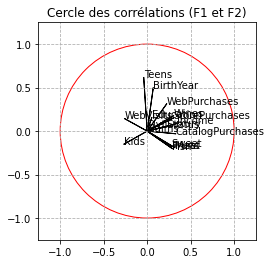

<Figure size 3600x3600 with 0 Axes>

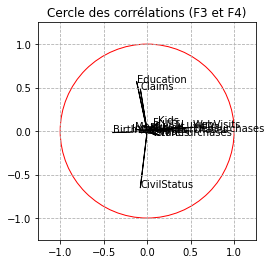

<Figure size 3600x3600 with 0 Axes>

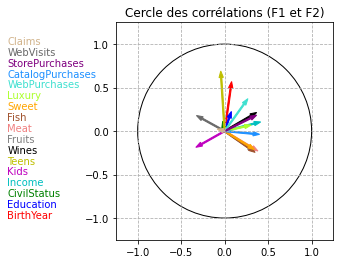

<Figure size 3600x3600 with 0 Axes>

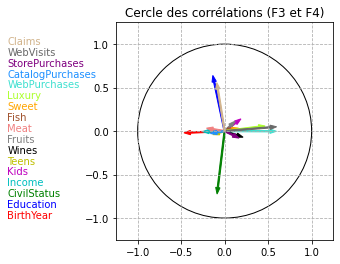

'\nfig = plt.figure(1, figsize=(50, 50))\ncircle1 = plt.Circle((0,0), 1, color=\'r\', fill=False)\nfig, ax = plt.subplots()\nplt.xlim(-1.25,1.25)\nplt.ylim(-1.25,1.25)\nplt.grid(linestyle=\'--\')\nplt.title("Cercle des corrélations (F5 et F6)")\nax.set_aspect(1)\nax.add_artist(circle1)\nfor i in range (13):\n  plt.arrow(0, 0, vecteursp[4][i], vecteursp[5][i])\n  plt.text(vecteursp[4][i],  vecteursp[5][i], columns[i])\n#plt.savefig(\'figsize_test0.png\')\nplt.show()\n'

In [ ]:
couleurs = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'grey', 'lightcoral', 'sienna', 'orange', 'greenyellow', 'turquoise', 'dodgerblue', 'purple', 'dimgrey', 'tan', 'olive']

# On crée maintenant les cercles de corrélation suivant les 2 premiers et les 2 derniers axes principaux
fig = plt.figure(1, figsize=(50, 50))
circle1 = plt.Circle((0,0), 1, color='r', fill=False)
fig, ax = plt.subplots()
plt.xlim(-1.25,1.25)
plt.ylim(-1.25,1.25)
plt.grid(linestyle='--')
plt.title("Cercle des corrélations (F1 et F2)")
ax.set_aspect(1)
ax.add_artist(circle1)
for i in range (17):
  plt.arrow(0, 0, vecteursp[0][i], vecteursp[1][i])
  plt.text(vecteursp[0][i],  vecteursp[1][i], columns[i])
#plt.savefig('figsize_test0.png')
plt.show()

fig = plt.figure(1, figsize=(50, 50))
circle1 = plt.Circle((0,0), 1, color='r', fill=False)
fig, ax = plt.subplots()
plt.xlim(-1.25,1.25)
plt.ylim(-1.25,1.25)
plt.grid(linestyle='--')
plt.title("Cercle des corrélations (F3 et F4)")
ax.set_aspect(1)
ax.add_artist(circle1)
for i in range (17):
  plt.arrow(0, 0, vecteursp[2][i], vecteursp[3][i])
  plt.text(vecteursp[2][i],  vecteursp[3][i], columns[i])
#plt.savefig('figsize_test0.png')
plt.show()

fig = plt.figure(1, figsize=(50, 50))
circle1 = plt.Circle((0,0), 1, color='k', fill=False)
fig, ax = plt.subplots()
plt.xlim(-1.25,1.25)
plt.ylim(-1.25,1.25)
plt.grid(linestyle='--')
plt.title("Cercle des corrélations (F1 et F2)")
ax.set_aspect(1)
ax.add_artist(circle1)
for i in range (17):
  plt.arrow(0, 0, vecteursp[0][i], vecteursp[1][i], color=couleurs[i], width=0.015, head_width=0.05)
  plt.text(-2.5,  -1 + (i/8), columns[i], color=couleurs[i])
#plt.savefig('figsize_test0.png')
plt.show()

fig = plt.figure(1, figsize=(50, 50))
circle1 = plt.Circle((0,0), 1, color='k', fill=False)
fig, ax = plt.subplots()
plt.xlim(-1.25,1.25)
plt.ylim(-1.25,1.25)
plt.grid(linestyle='--')
plt.title("Cercle des corrélations (F3 et F4)")
ax.set_aspect(1)
ax.add_artist(circle1)
for i in range (17):
  plt.arrow(0, 0, vecteursp[2][i], vecteursp[3][i], color=couleurs[i], width=0.015, head_width=0.05)
  plt.text(-2.5,  -1 + (i/8), columns[i], color=couleurs[i])
#plt.savefig('figsize_test0.png')
plt.show()

"""
fig = plt.figure(1, figsize=(50, 50))
circle1 = plt.Circle((0,0), 1, color='r', fill=False)
fig, ax = plt.subplots()
plt.xlim(-1.25,1.25)
plt.ylim(-1.25,1.25)
plt.grid(linestyle='--')
plt.title("Cercle des corrélations (F5 et F6)")
ax.set_aspect(1)
ax.add_artist(circle1)
for i in range (13):
  plt.arrow(0, 0, vecteursp[4][i], vecteursp[5][i])
  plt.text(vecteursp[4][i],  vecteursp[5][i], columns[i])
#plt.savefig('figsize_test0.png')
plt.show()
"""

## **2.5)  Clustering des données**

In [ ]:
nb_clusters = 4 # on définit le nombre de clusters à 4
t = 50  #La distance t à 50 pour le Clustering Ascendant Hierarchique
eps = 0.1 # La valeur epsilon à 0.1 pour la méthode DBSCAN

### **Méthode de clustering K-Means**

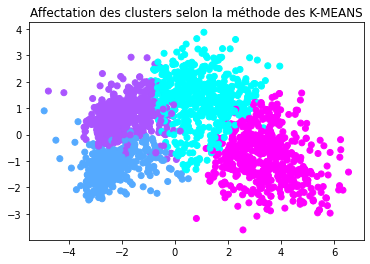

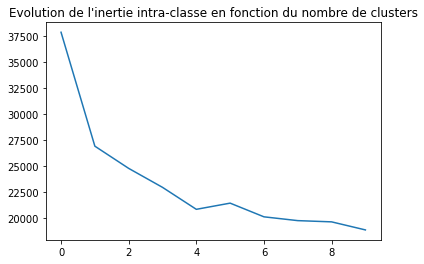

In [ ]:
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# On a déjà normalisé les données

# On réalise la méthode de KMeans sur les 2 premiers axes principaux
kmeans = KMeans(n_clusters=nb_clusters, init='random', n_init=1).fit(Z)
affectation_cluster = kmeans.labels_
plt.scatter(Zt[:2229,0], Zt[:2229,1], c=affectation_cluster, cmap='cool')
plt.title ('Affectation des clusters selon la méthode des K-MEANS')
plt.show()

# puis on affiche le graphique de l'évolution de l'inertie intra-classe afin de définir le meilleur nombre de clusters
inertie =[]
for i in range (1,11):
  kmeans = KMeans(n_clusters=i, init='random', n_init=1).fit(Z)
  inertie.append (kmeans.inertia_)
plt.plot(inertie)
plt.title ("Evolution de l'inertie intra-classe en fonction du nombre de clusters")
plt.show()


### **Méthode de clustering CAH**

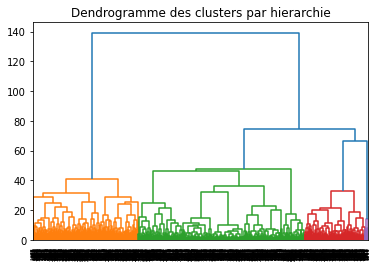

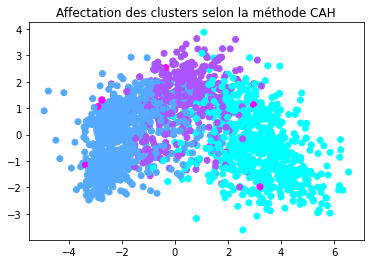

In [ ]:
linkage1 = linkage (Z, 'ward', 'euclidean', True) # On réalise maintenant la méthode de CAH et on choisit la distance de Ward car plus précise
affectation_cluster_cah = fcluster (linkage1, t, criterion='distance')
dendrogram (linkage1, color_threshold=t)  #On affiche le dendrogram pour pouvoir déterminer une bonne distance t et obtenir ainsi le nombre de cluster optimal
plt.title ('Dendrogramme des clusters par hierarchie')
plt.show()
plt.scatter(Zt[:2229,0], Zt[:2229,1], c=affectation_cluster_cah, cmap='cool')
plt.title ('Affectation des clusters selon la méthode CAH')
plt.show()

### **Méthode de clustering modèle de mélange de Gaussienne**

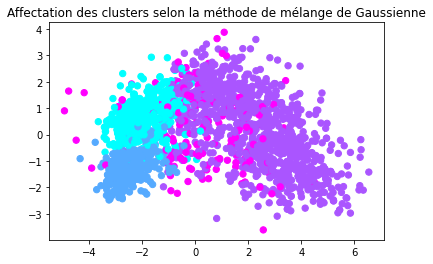

In [ ]:
gm = GaussianMixture(n_components=nb_clusters).fit(Z) #On représente maintenant le nuage de points avec la méthode de mélange de Gaussienne
labels = gm.predict(Z)
plt.scatter(Zt[:2229,0], Zt[:2229,1], c=labels, s=40, cmap='cool')
plt.title ('Affectation des clusters selon la méthode de mélange de Gaussienne')
plt.show()

### **Méthode de clustering DBSCAN**

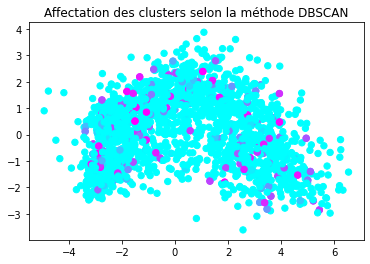

In [ ]:
dbscan = DBSCAN(eps=eps, min_samples=2).fit(Z)  # Ici, on calcule la méthode de clustering DBSCAN à l'aide de la variable epsilon définie au-dessus
labels2 = dbscan.labels_                        # on obtient -1 lorsqu'il y a une anomalie
plt.scatter(Zt[:2229,0], Zt[:2229,1], c=labels2, s=40, cmap='cool')
plt.title ('Affectation des clusters selon la méthode DBSCAN')
plt.show()


### **Méthode du partionnement spectral**

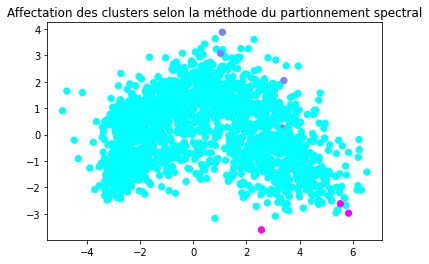

In [ ]:
spectralClustering = SpectralClustering(n_clusters=nb_clusters, assign_labels='discretize', random_state=0).fit(Z)
labels3 = spectralClustering.labels_      #Enfin, on réalise la méthode du pationnement spectral sur nos données
plt.scatter(Zt[:2229,0], Zt[:2229,1], c=labels3, s=40, cmap='cool')
plt.title ('Affectation des clusters selon la méthode du partionnement spectral')
plt.show()

## **Interprétation des données**

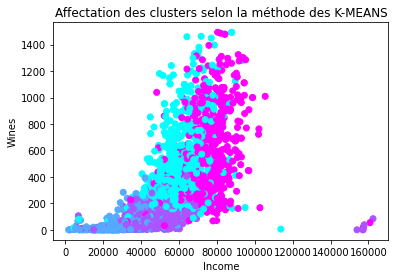

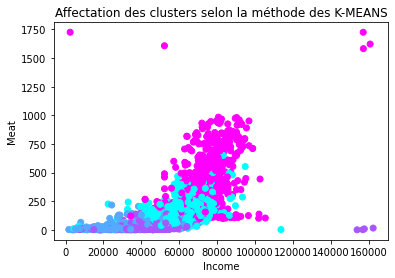

In [ ]:
# Maintenant, on souhaite interpréter nos données, on cherche donc à représenter 2 colonnes ayant un corrélation entre elles (positive ou négative) afin
# de repérer des clusters particuliers à l'aide de la méthode Kmeans réalisée auparavant, la plus efficace
# Ici, on repésente 2 graphiques, le premier comparant le vin et les revenus et le second la viande et les revenus

plt.scatter(filled_customer['Income'], filled_customer['Wines'], c=affectation_cluster, cmap='cool')
plt.title ('Affectation des clusters selon la méthode des K-MEANS')
plt.xlabel('Income')
plt.ylabel('Wines')
plt.show()

plt.scatter(filled_customer['Income'], filled_customer['Meat'], c=affectation_cluster, cmap='cool')
plt.title ('Affectation des clusters selon la méthode des K-MEANS')
plt.xlabel('Income')
plt.ylabel('Meat')
plt.show()

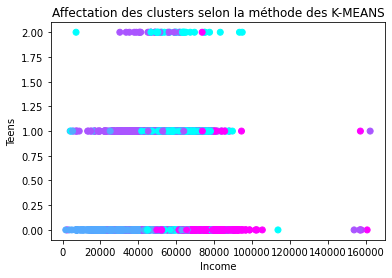

In [ ]:
# On représente un dernier graphique comparant le nombre d'adolescent du ménage avec les revenus

plt.scatter(filled_customer['Income'], filled_customer['Teens'], c=affectation_cluster, cmap='cool')
plt.title ('Affectation des clusters selon la méthode des K-MEANS')
plt.xlabel('Income')
plt.ylabel('Teens')
plt.show()